In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# ! scp -r arnab_sen_sharma@compute.safe.ai:/data/arnab_sen_sharma/Projects/relations/results ../../

In [3]:
import sys
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
import os
from src import data
import json

In [4]:
############################################
sweep_root = "../../results/sweep"
model_name = "gptj"
############################################

sweep_path = f"{sweep_root}/{model_name}"

In [5]:
from src.sweeps import (
    SweepRelationResults,
    SweepTrialResults,
    SweepLayerResults,
    SweepTrainResults,
    SweepBetaResults, SweepRankResults, EfficacyTestPair
)
from src.data import RelationSample

def parse_results(sweep_result):
    relation_results = SweepRelationResults(
        relation_name=sweep_result["relation_name"],
        trials = []
    )

    for trial in sweep_result["trials"]:
        trial_results = SweepTrialResults(
            prompt_template=trial["prompt_template"],
            train_samples=[RelationSample.from_dict(s) for s in trial["train_samples"]],
            layers = [],
            n_test_samples=trial["n_test_samples"],
        )
        for layer in trial["layers"]:
            train_results = SweepTrainResults(
                samples = [RelationSample.from_dict(s) for s in layer["result"]["samples"]],
                betas = [],
                ranks = [],
                jh_norm=layer["result"]["jh_norm"],
            )
            for beta in layer["result"]["betas"]:
                beta_results = SweepBetaResults(
                    beta = beta["beta"],
                    recall = beta["recall"],
                    faithfulness_successes=[
                        RelationSample.from_dict(s) for s in beta["faithfulness_successes"]
                    ]
                )
                train_results.betas.append(beta_results)

            for rank in layer["result"]["ranks"]:
                rank_results = SweepRankResults(
                    rank = rank["rank"],
                    efficacy = rank["efficacy"],
                    efficacy_successes=[
                        EfficacyTestPair(
                            source=RelationSample.from_dict(s["source"]),
                            target=RelationSample.from_dict(s["target"]),
                        )
                        for s in rank["efficacy_successes"]
                    ]
                )
                train_results.ranks.append(rank_results)
            
            layer_results = SweepLayerResults(
                layer=layer["layer"],
                result=train_results
            )

            trial_results.layers.append(layer_results)
        relation_results.trials.append(trial_results)
    return relation_results

In [32]:
def plot_layerwise(canvas, relation_result, attribute = "recall", best_criterion = "faithfulness"):
    by_layer = relation_result.by_layer()

    layers = by_layer.keys()
    value_means = [value.__dict__[attribute].mean for value in by_layer.values()]
    value_stds = [value.__dict__[attribute].stdev for value in by_layer.values()]

    if(best_criterion == "faithfulness"):
        best_layer = relation_result.best_by_faithfulness()
    elif(best_criterion == "efficacy"):
        best_layer = relation_result.best_by_efficacy()
    canvas.scatter([best_layer.layer], [best_layer.__dict__[attribute].mean], color="red", s=200)
    canvas.plot(range(len(layers)), value_means, color='darkblue', linewidth=2)
    canvas.fill_between(range(len(layers)), np.array(value_means) - np.array(value_stds), np.array(value_means) + np.array(value_stds), color='lightblue', alpha=0.5)

    if attribute in ["recall", "efficacy"]:
        canvas.set_ylim(0, 1)
    else:
        canvas.set_ylim(bottom=0)
    canvas.set_xlabel("Layer")
    canvas.set_ylabel(attribute)
    canvas.set_xticks(range(len(layers)), layers, rotation=90)
    test_samples = [trial.n_test_samples for trial in relation_result.trials]
    canvas.set_title(f"{relation_result.relation_name} {test_samples}\n{best_criterion} => h_layer: {best_layer.layer}, beta: {best_layer.beta.mean:.2f}, rank: {best_layer.rank.mean:.2f}, efficacy: {best_layer.efficacy.mean:.2f}")
    
    return canvas

In [26]:
def read_sweep_results(sweep_path):
    sweep_results = {}

    for relation_folder in os.listdir(sweep_path):
        cur_sweep = f"{sweep_path}/{relation_folder}"
        if "results_all.json" not in os.listdir(cur_sweep):
            continue
        with open(f"{cur_sweep}/results_all.json") as f:
            res = json.load(f)["relations"]
            if(len(res) == 0):
                continue
            res = res[0]
            sweep_results[res["relation_name"]] = res
    return sweep_results

sweep_results = read_sweep_results(sweep_path)

list(sweep_results.keys())

['person occupation',
 'adjective antonym',
 'person mother',
 'country capital city',
 'plays pro sport',
 'person plays instrument',
 'person university',
 'city in country',
 'food from country',
 'company hq',
 'occupation gender',
 'name gender',
 'word first letter',
 'country language',
 'object superclass',
 'name religion',
 'president election year',
 'fruit outside color',
 'superhero archnemesis',
 'work location',
 'person lead singer of band',
 'task person type',
 'country largest city',
 'country currency',
 'fruit inside color',
 'task done by tool',
 'verb past tense',
 'star constellation name',
 'pokemon evolution',
 'product by company',
 'name birthplace',
 'word last letter',
 'word sentiment',
 'company CEO',
 'superhero person',
 'person father',
 'substance phase of matter',
 'person sport position',
 'adjective superlative',
 'adjective comparative']

In [27]:
# dataset = data.load_dataset()
# all_relations = [
#     relation.name for relation in dataset.relations
# ]
# all_relations = sorted(all_relations)
# # all_relations
# failed_relations = list(set(all_relations) - set(sweep_results.keys()))
# failed_relations = sorted(failed_relations)
# failed_relations

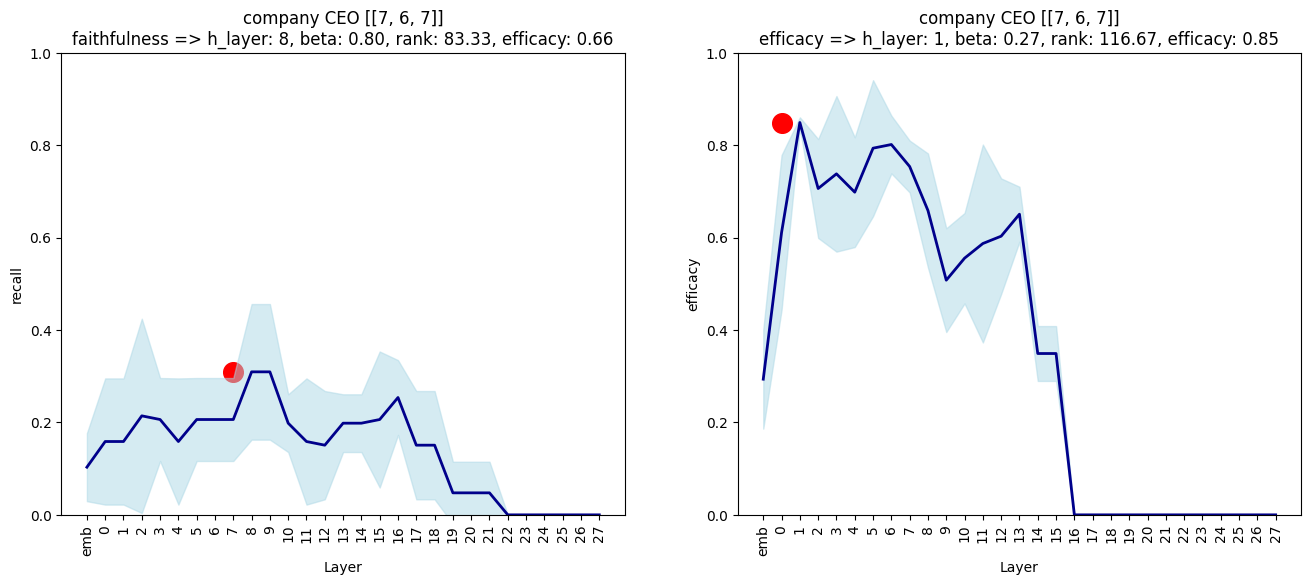

In [28]:
relation_result = parse_results(sweep_results['company CEO'])

nrows = 1
ncols = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 6))

plot_layerwise(ax[0], relation_result)
plot_layerwise(ax[1], relation_result, attribute="efficacy", best_criterion="efficacy")

fig.show()

In [29]:
dataset = data.load_dataset()
interested_dataset = dataset.filter(
    # relation_type = ["factual"]
)

filtered_results = {}
for relation in interested_dataset.relations:
    if relation.name not in sweep_results:
        continue
    filtered_results[relation.name] = parse_results(sweep_results[relation.name])

In [30]:
len(filtered_results)

40

0 name birthplace
1 name gender
2 name religion
3 occupation gender
4 fruit inside color
5 fruit outside color
6 object superclass
7 substance phase of matter
8 task person type
9 task done by tool
10 word sentiment
11 work location
12 city in country
13 company CEO
14 company hq
15 country capital city
16 country currency
17 country language
18 country largest city
19 food from country
20 person lead singer of band
21 person father
22 person mother
23 person occupation
24 person plays instrument
25 person sport position
26 plays pro sport
27 person university
28 pokemon evolution
29 president election year
30 product by company
31 star constellation name
32 superhero archnemesis
33 superhero person
34 adjective antonym
35 adjective comparative
36 adjective superlative
37 verb past tense
38 word first letter
39 word last letter


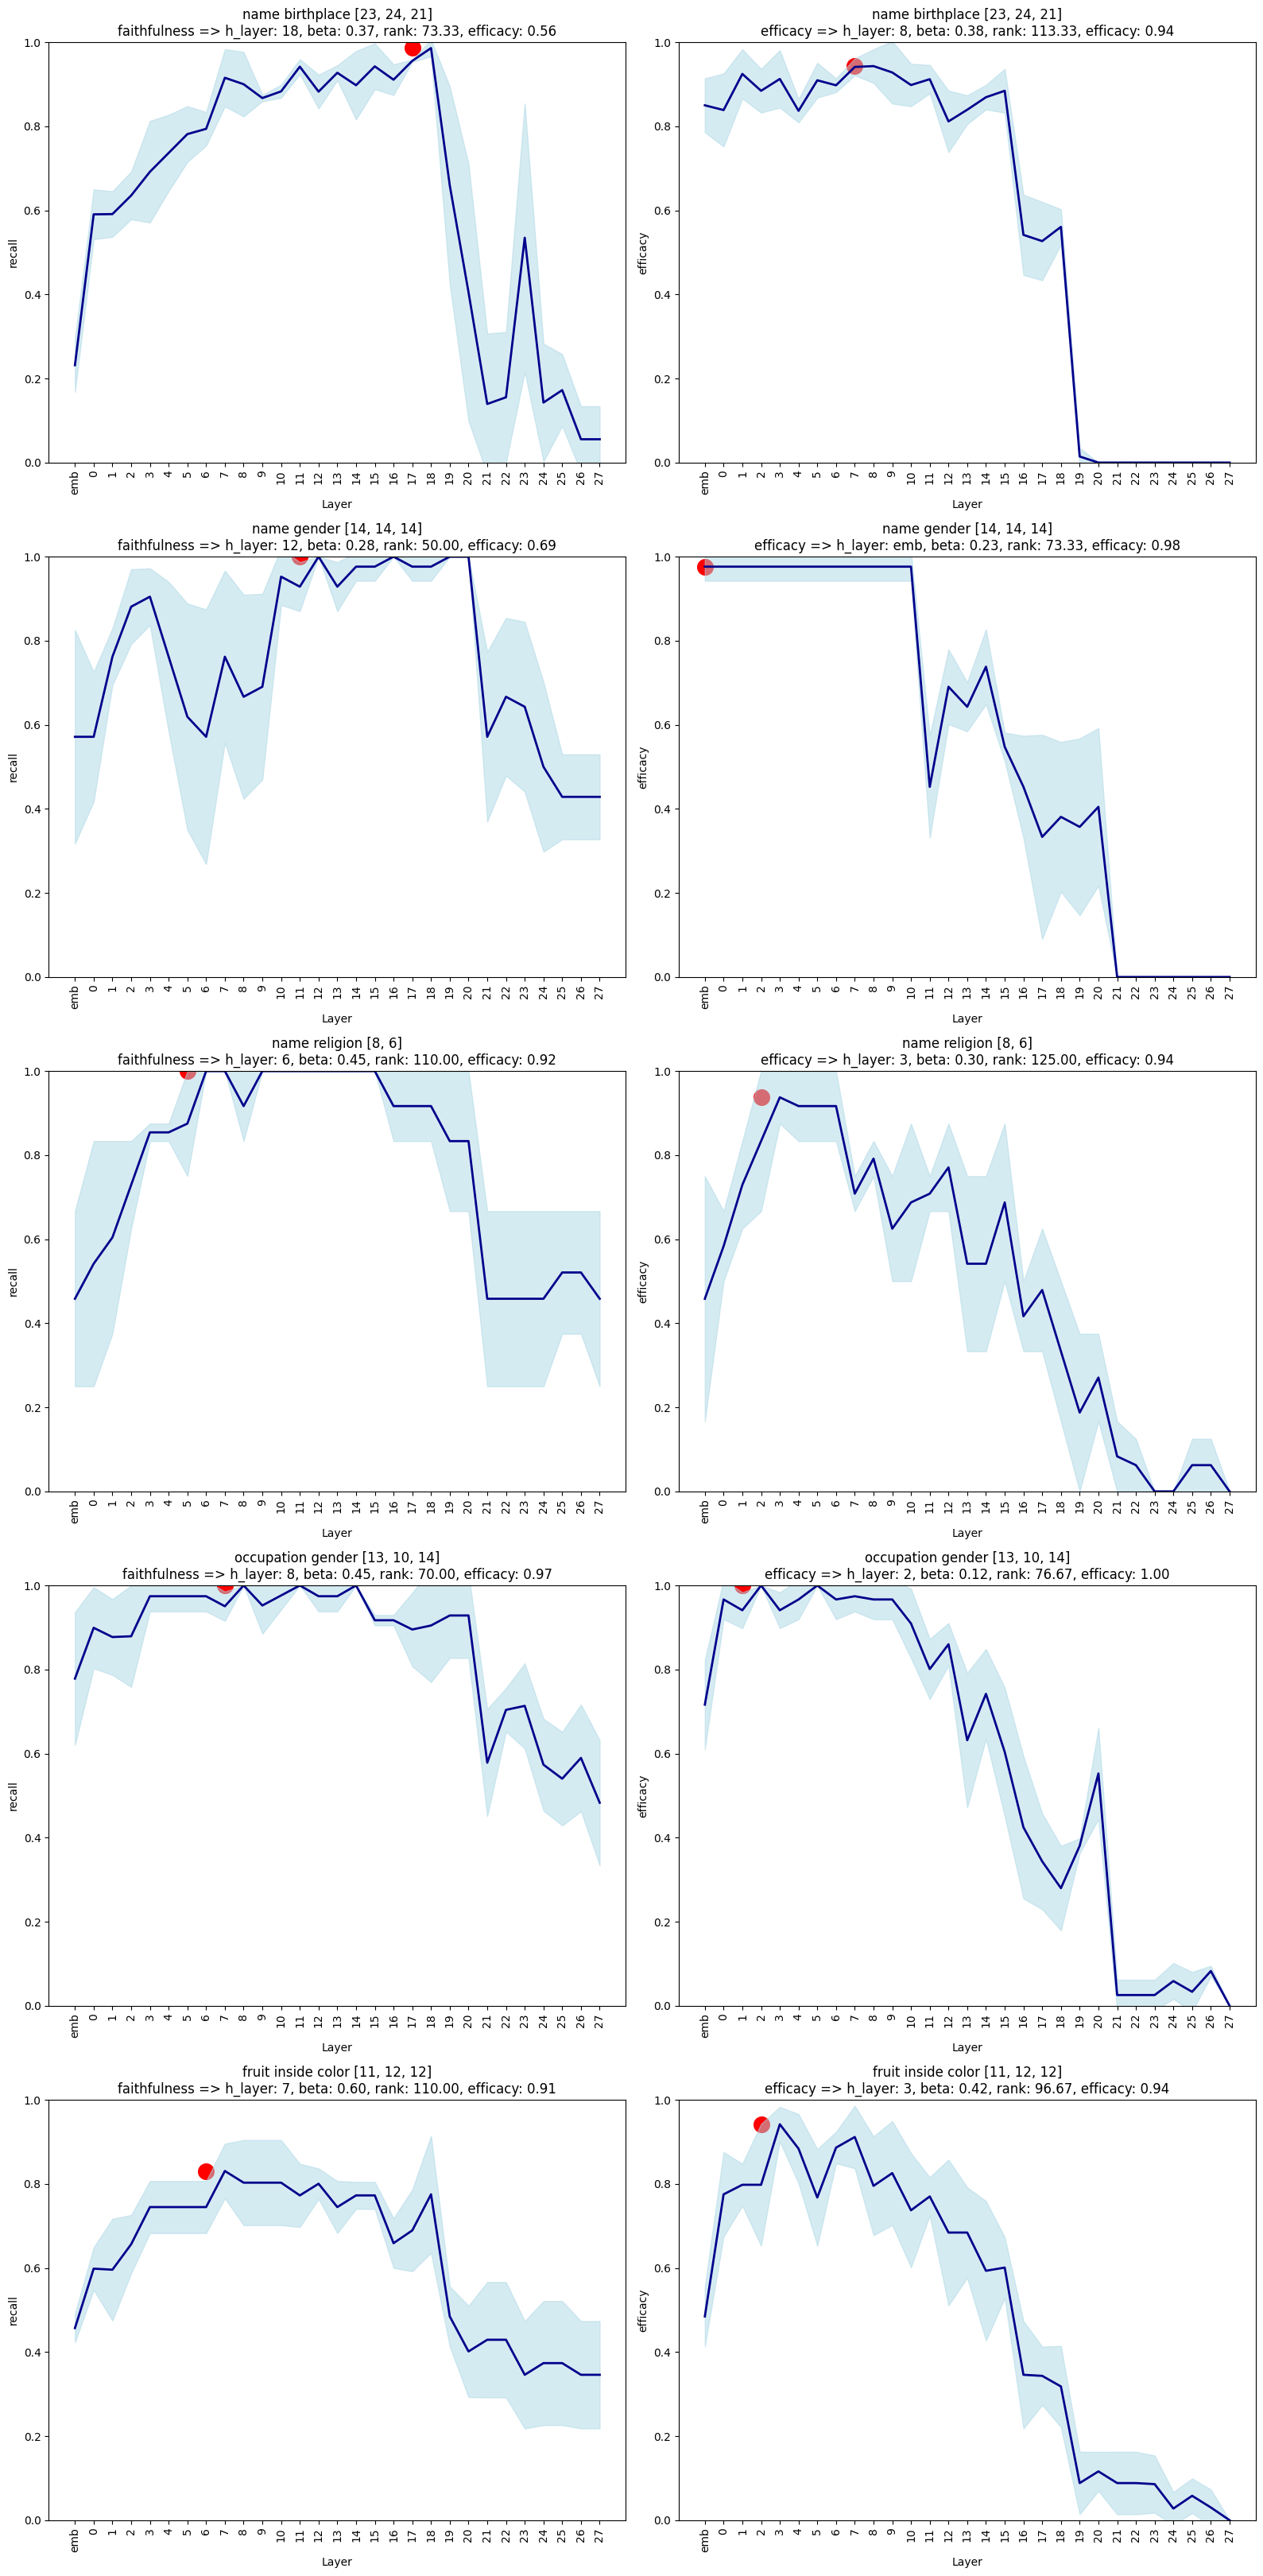

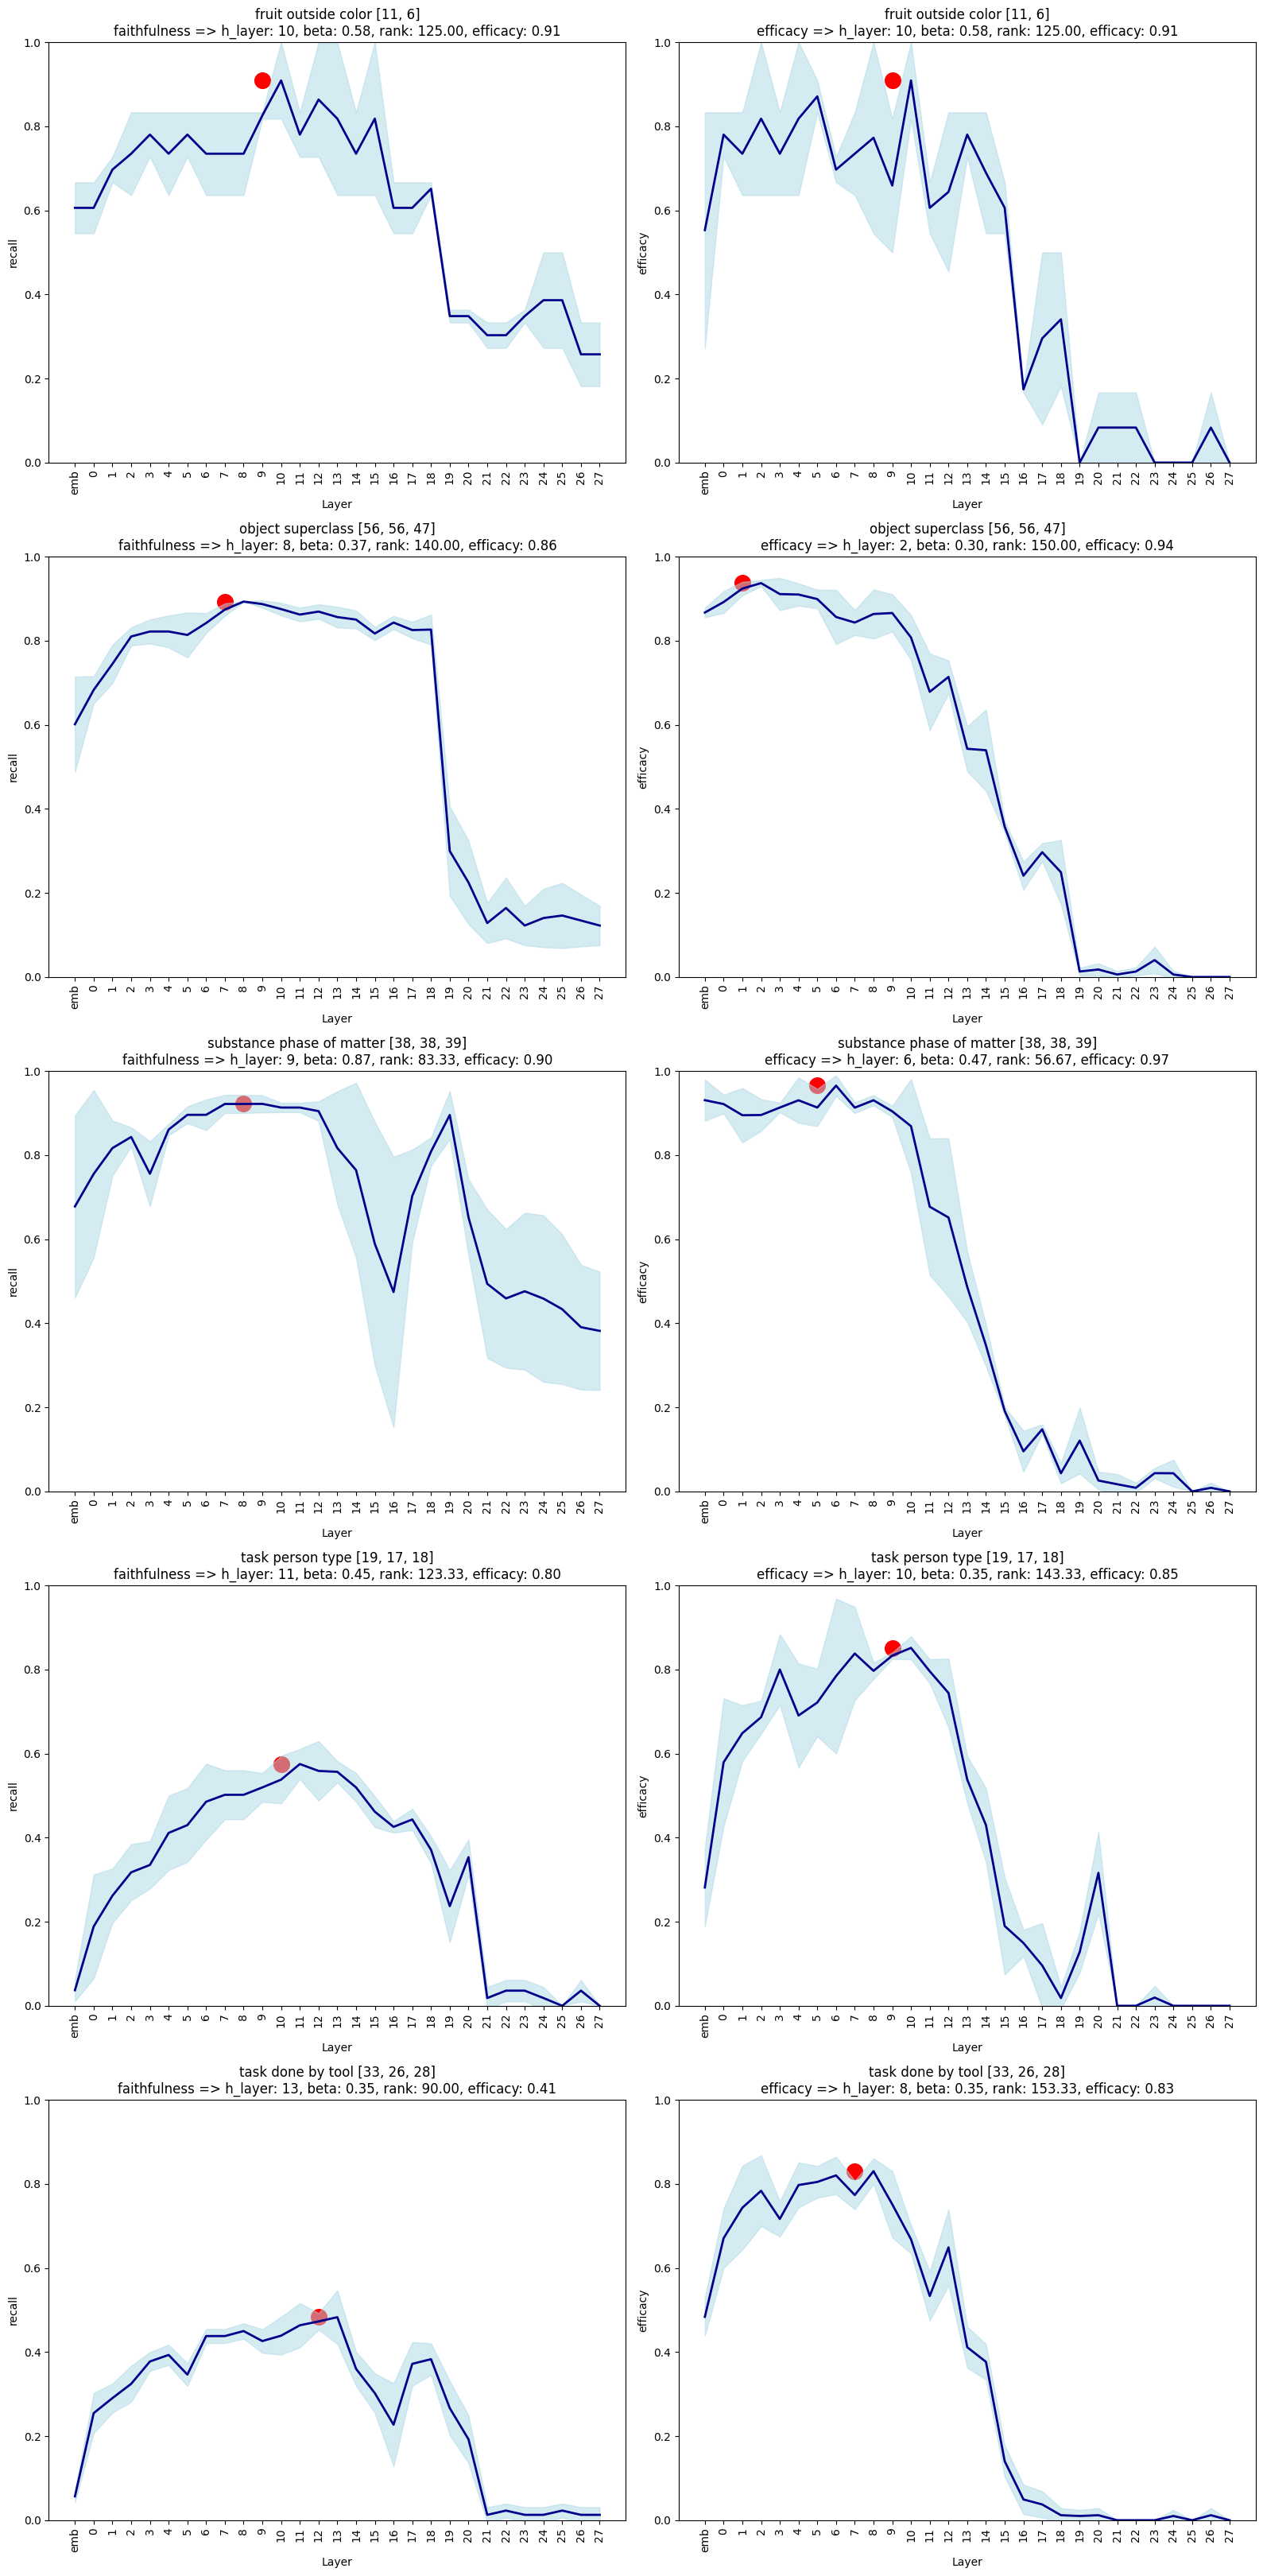

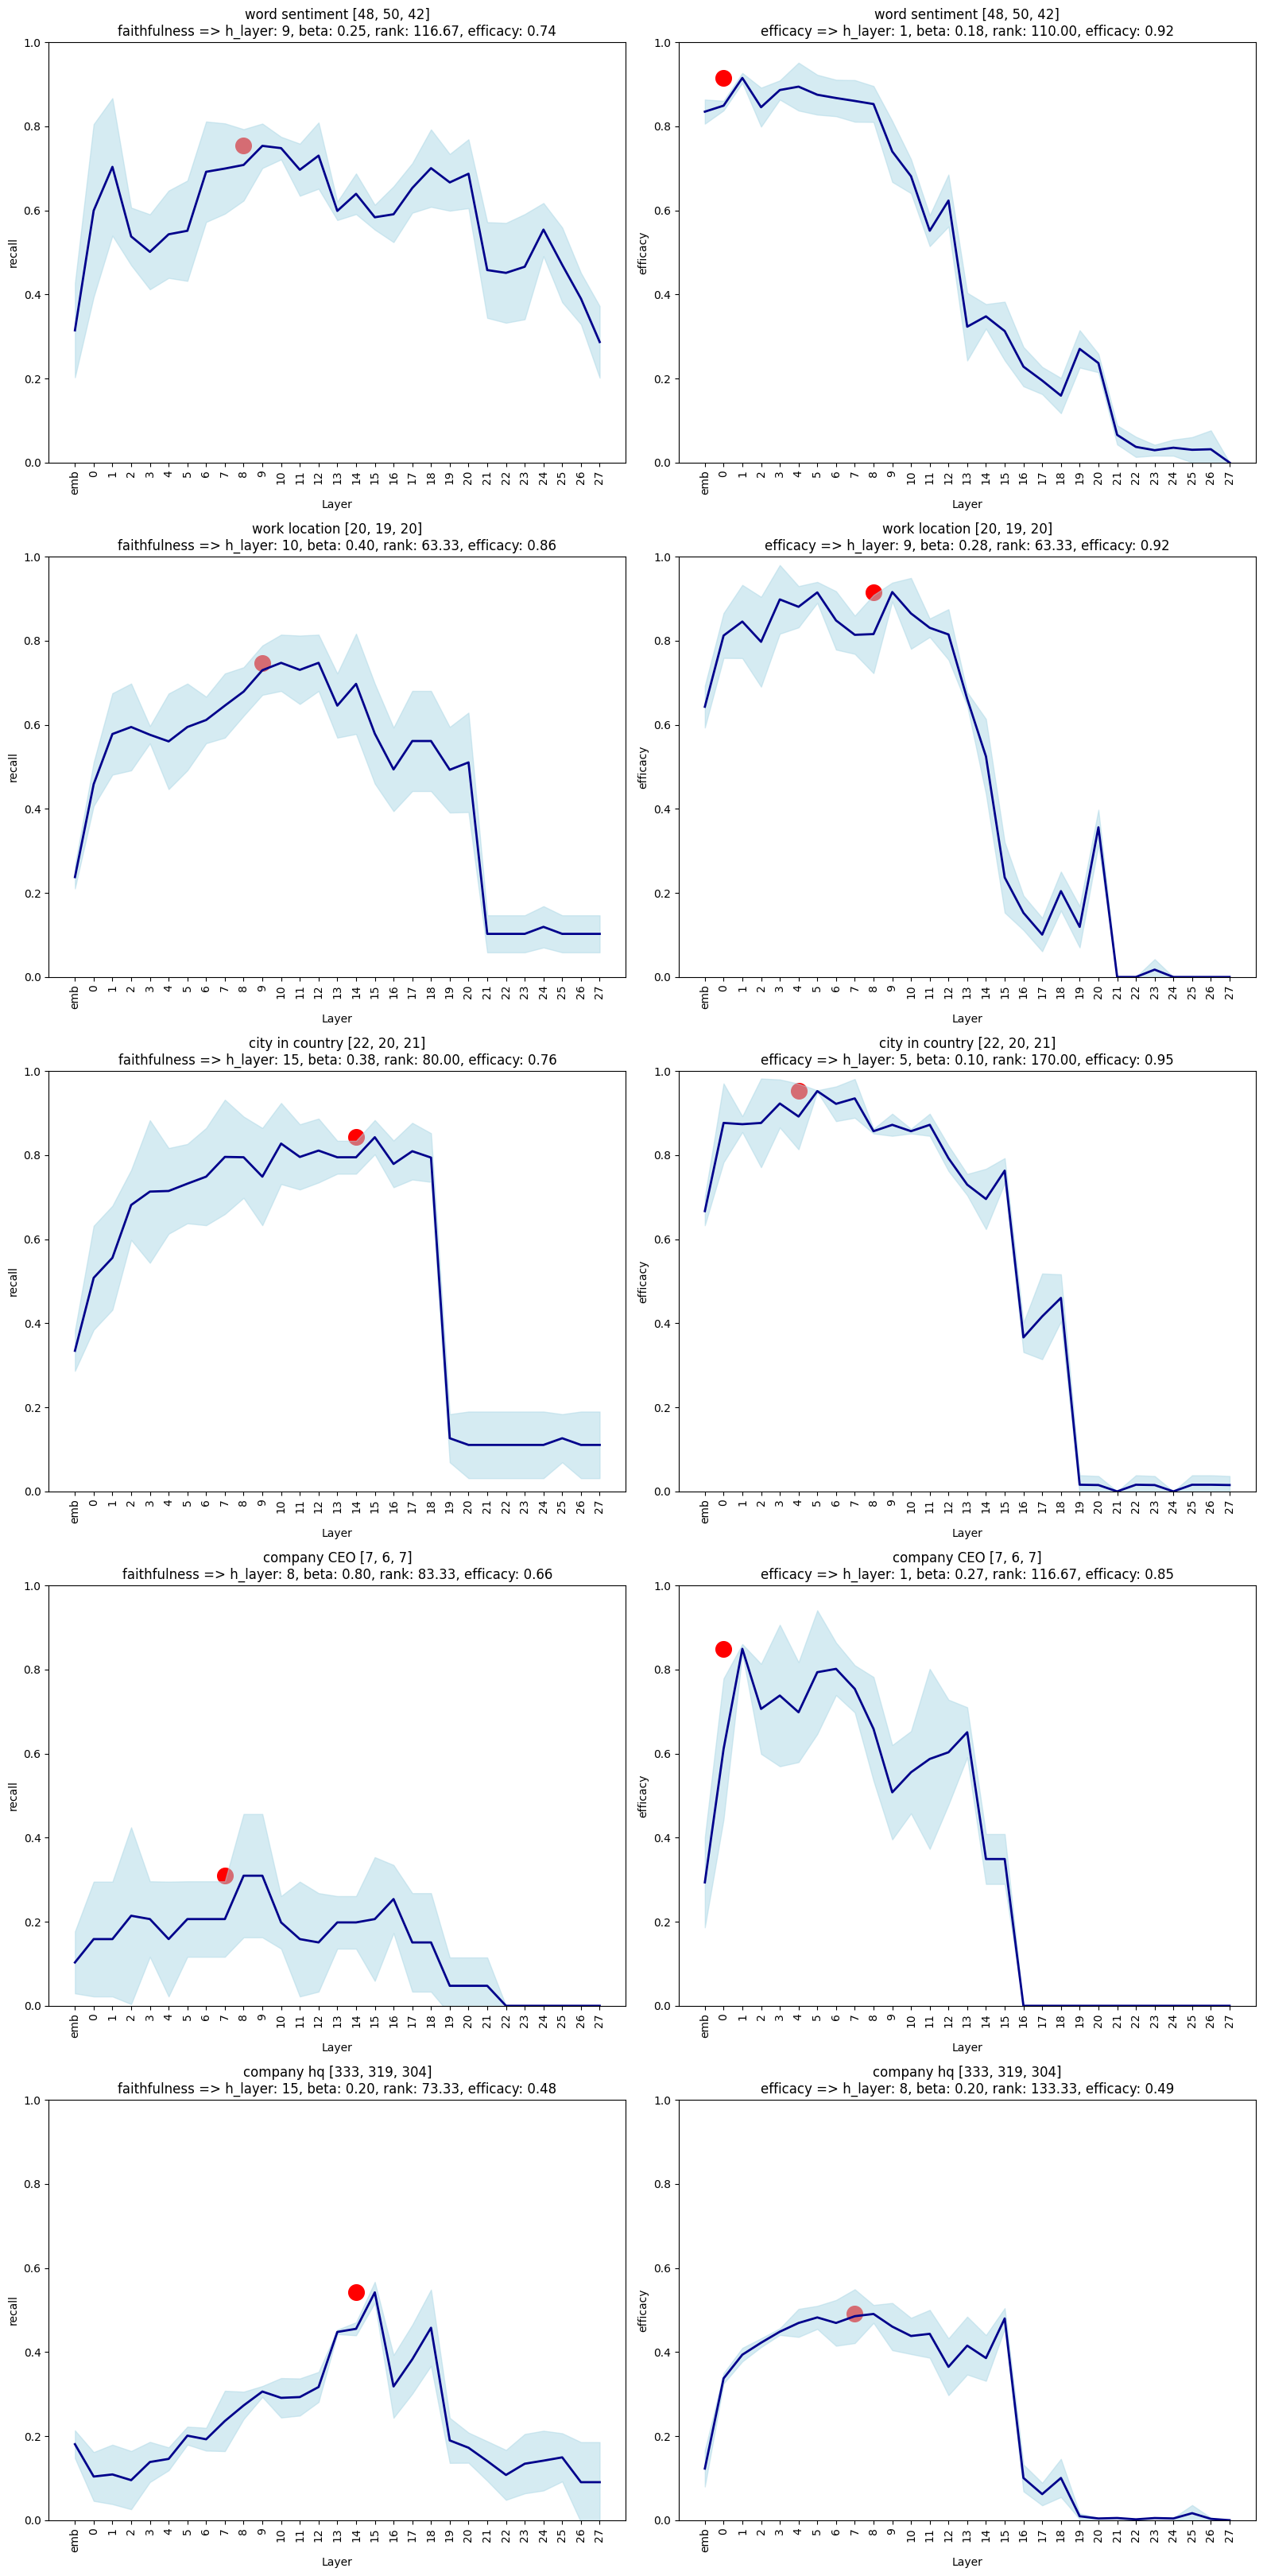

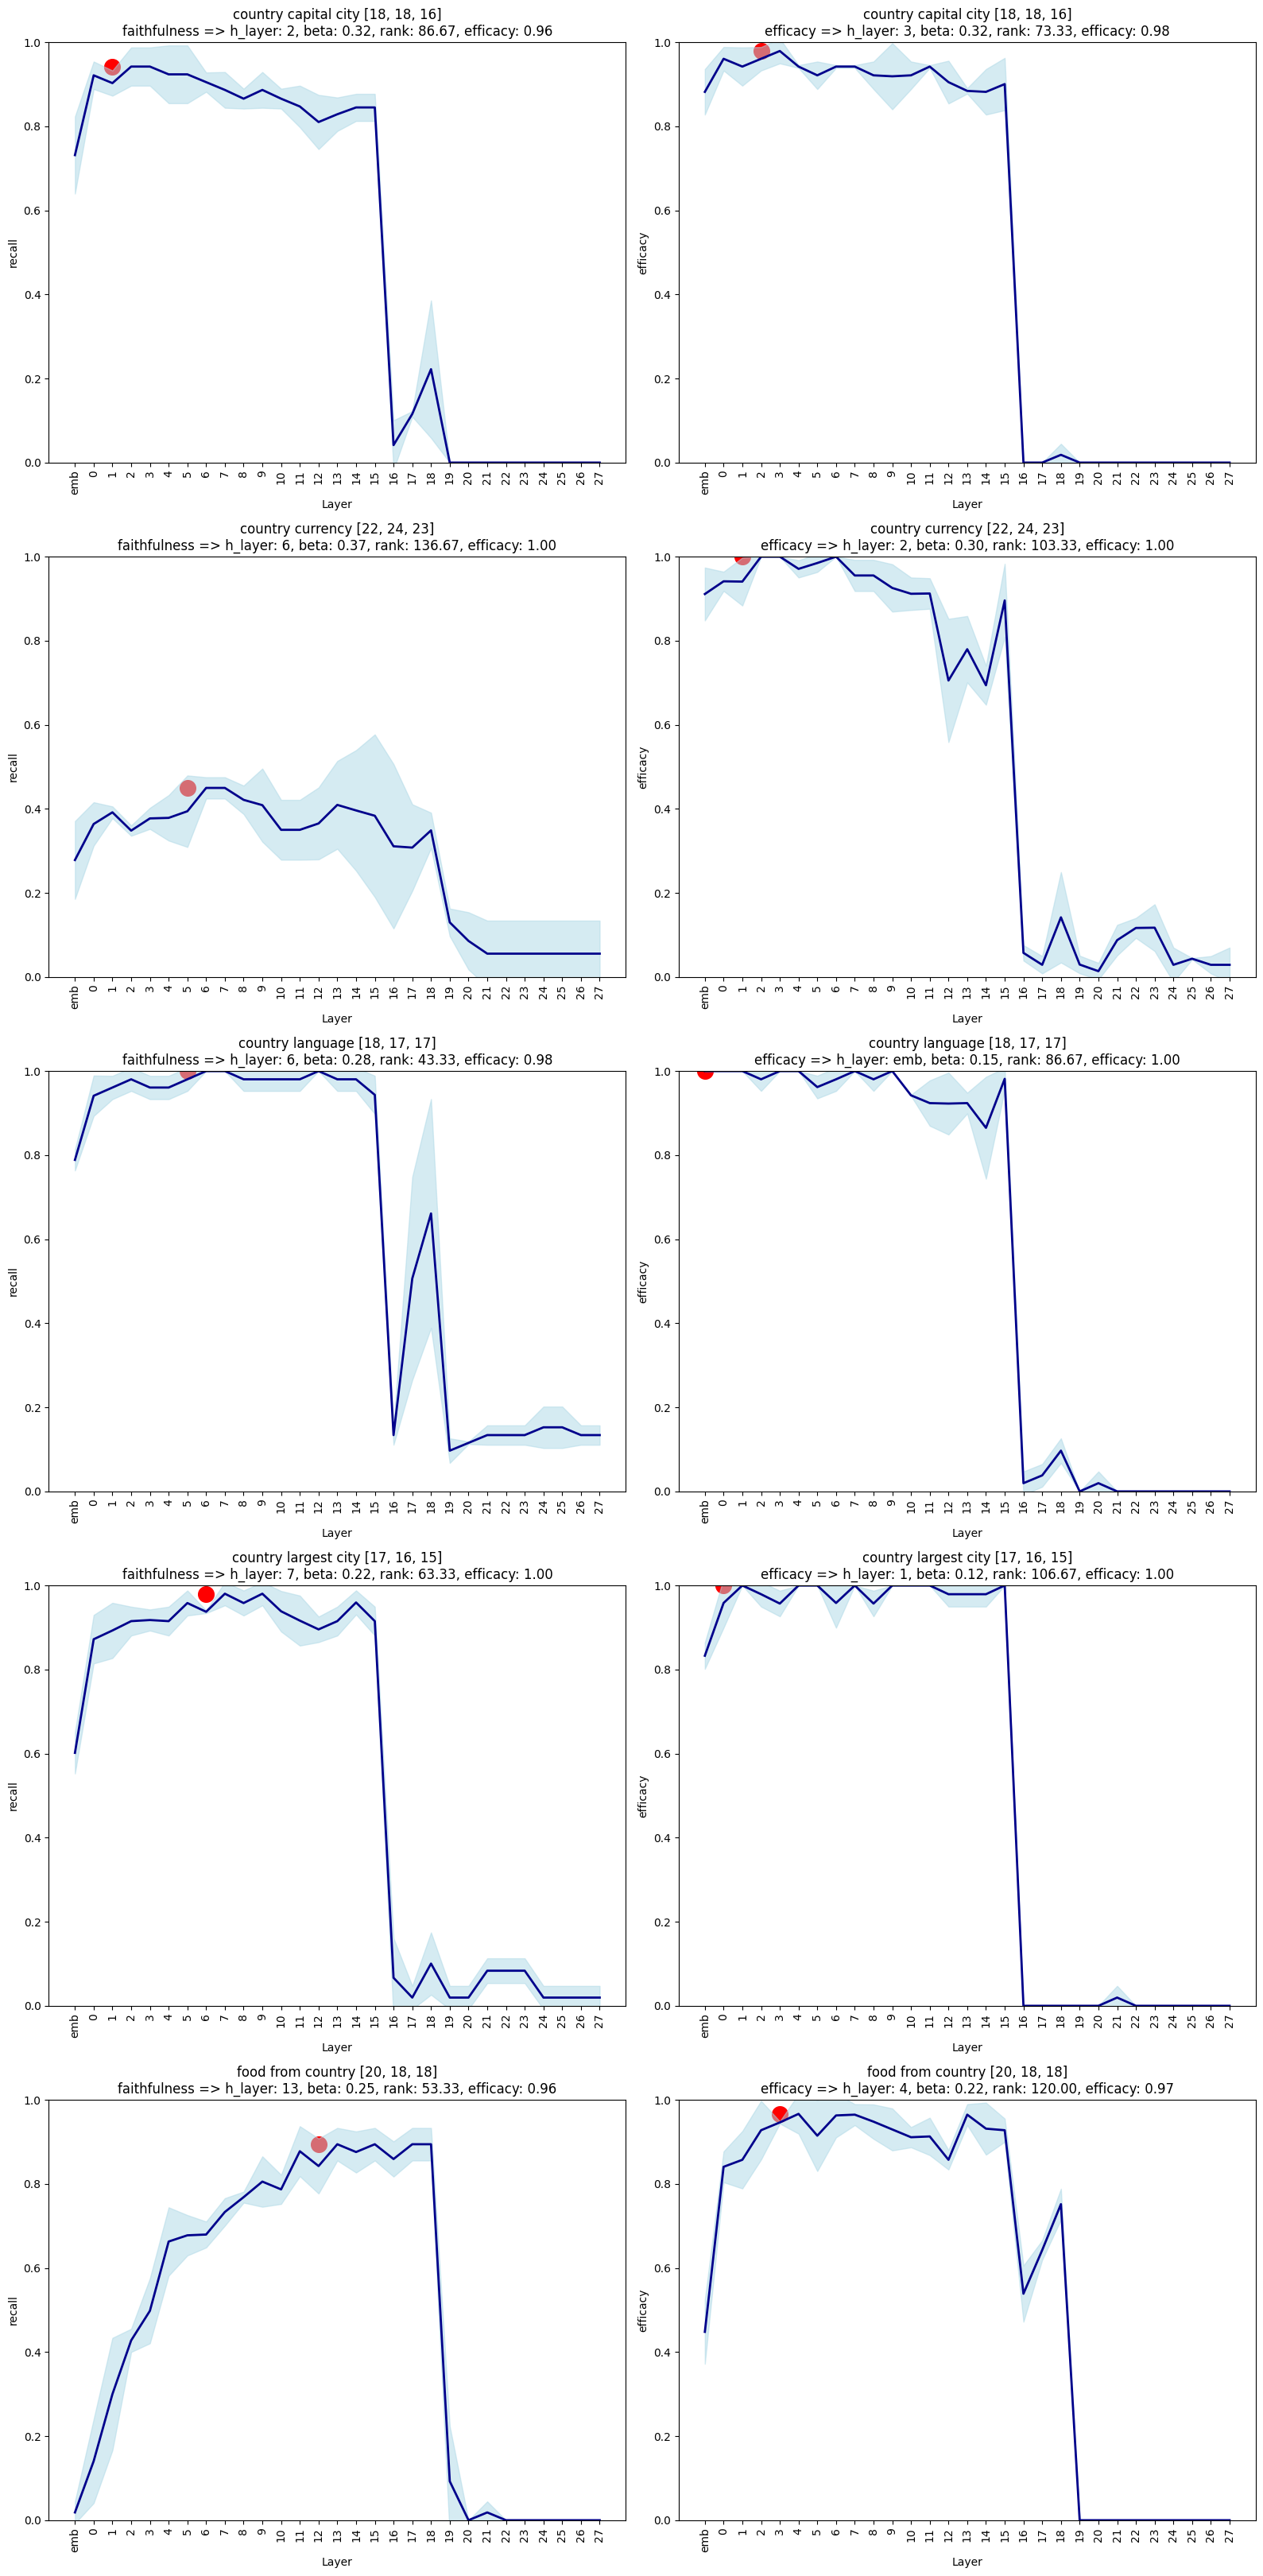

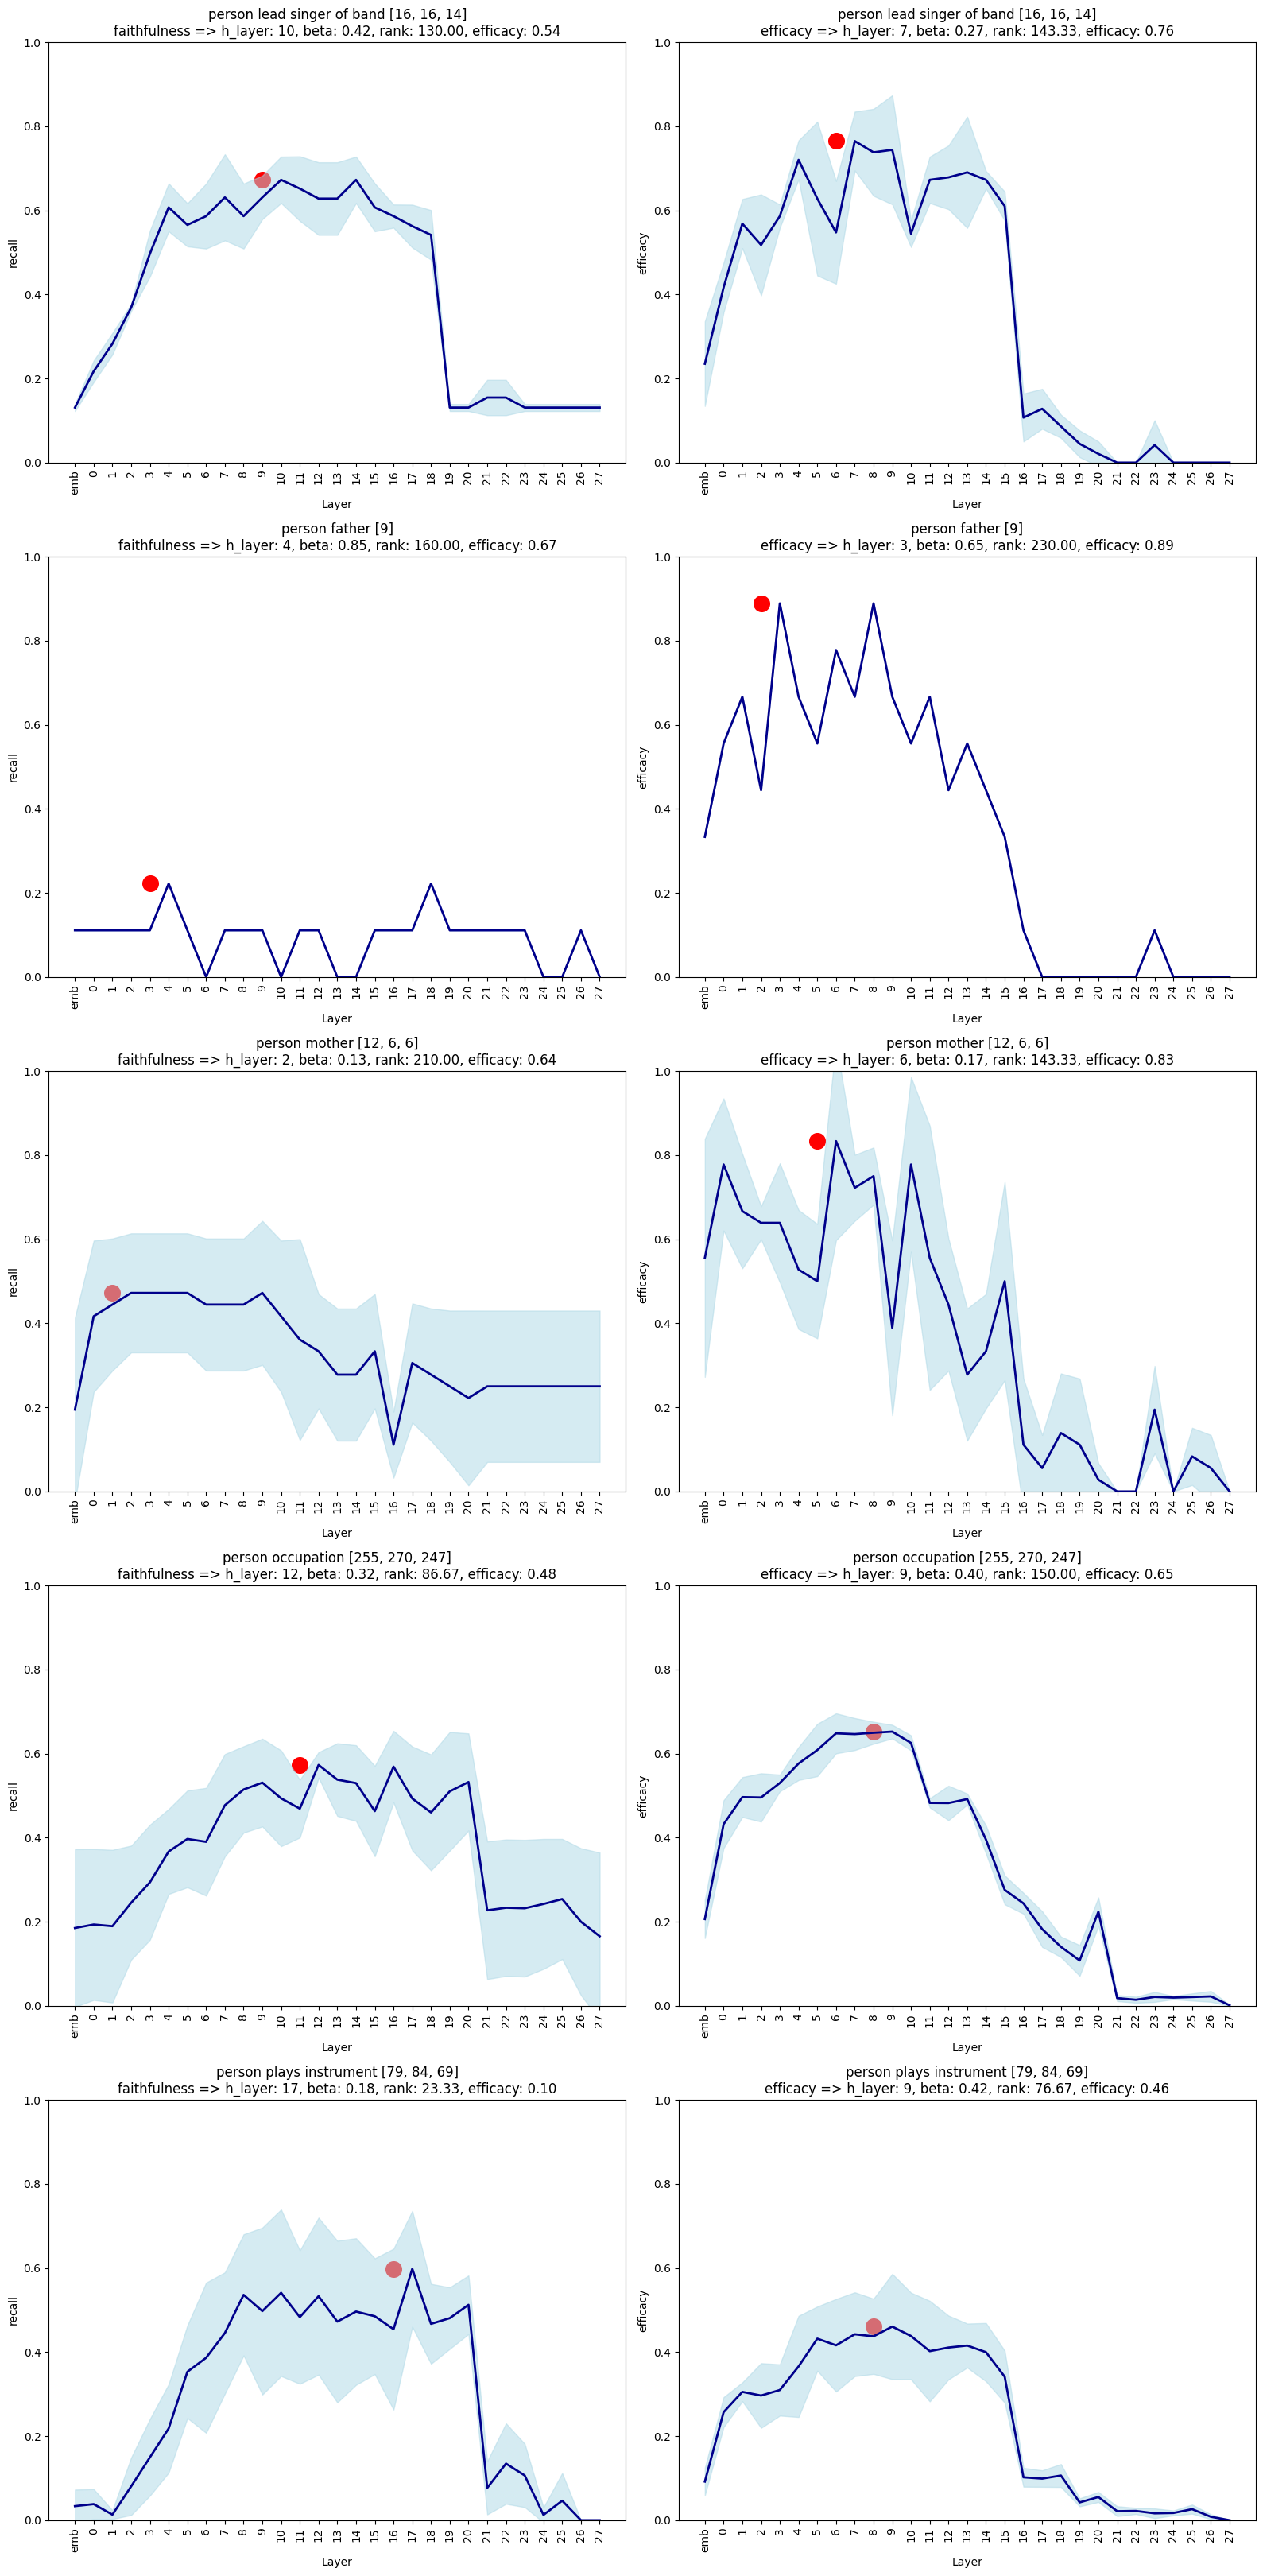

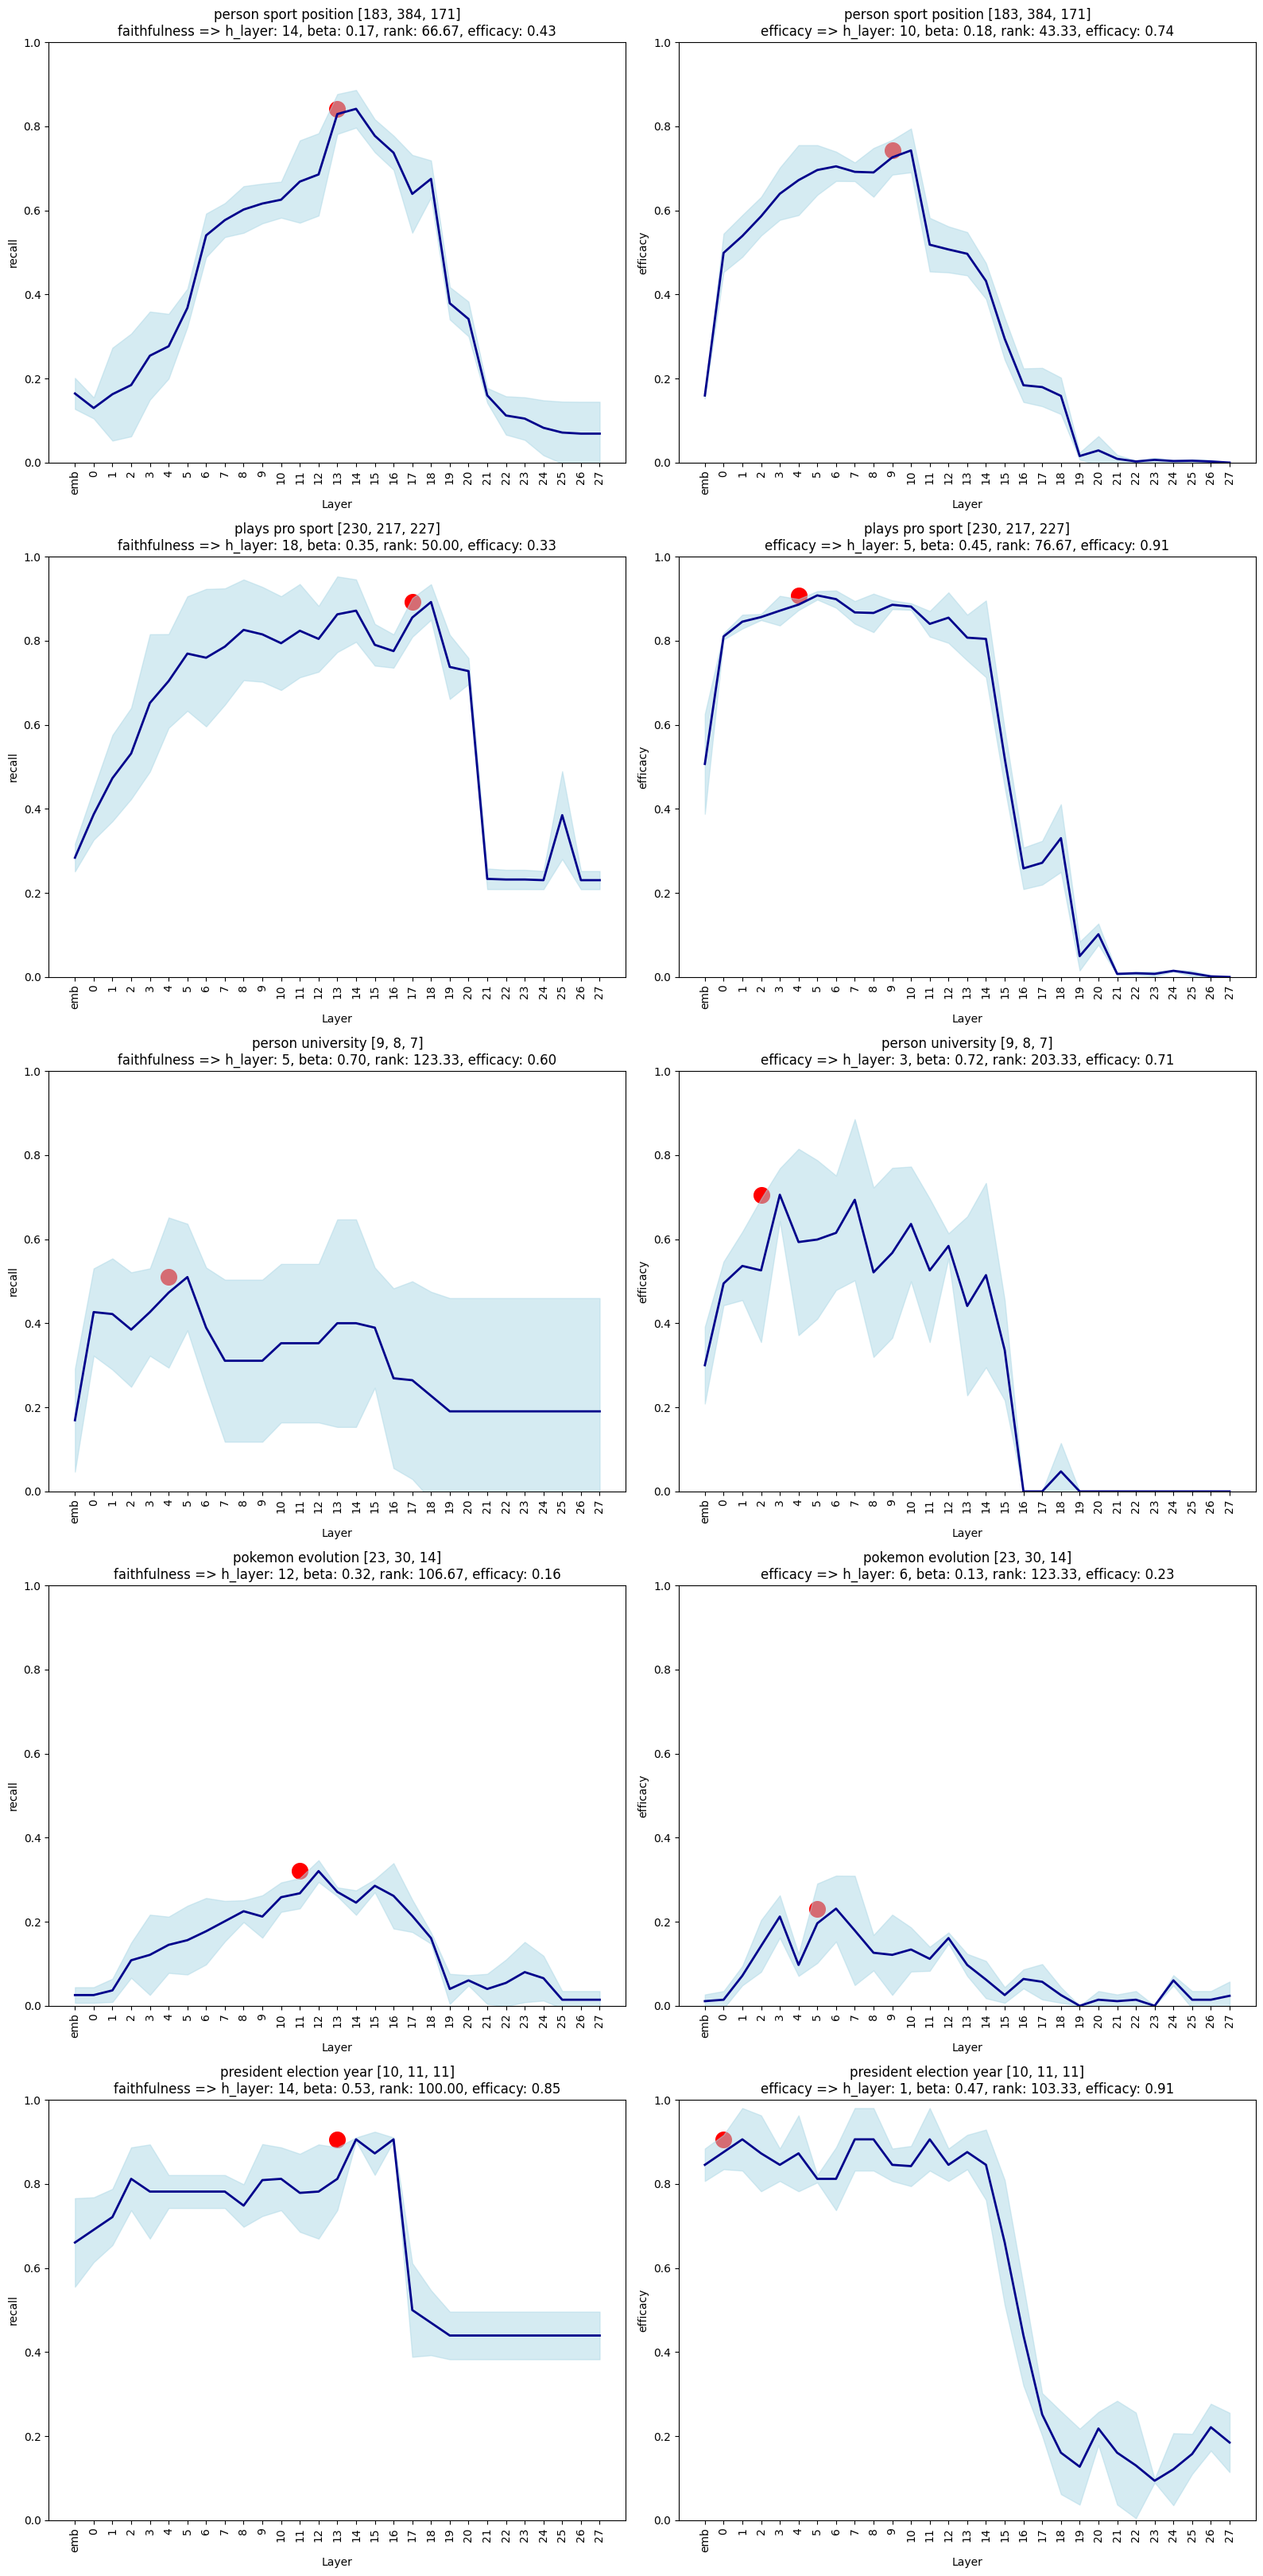

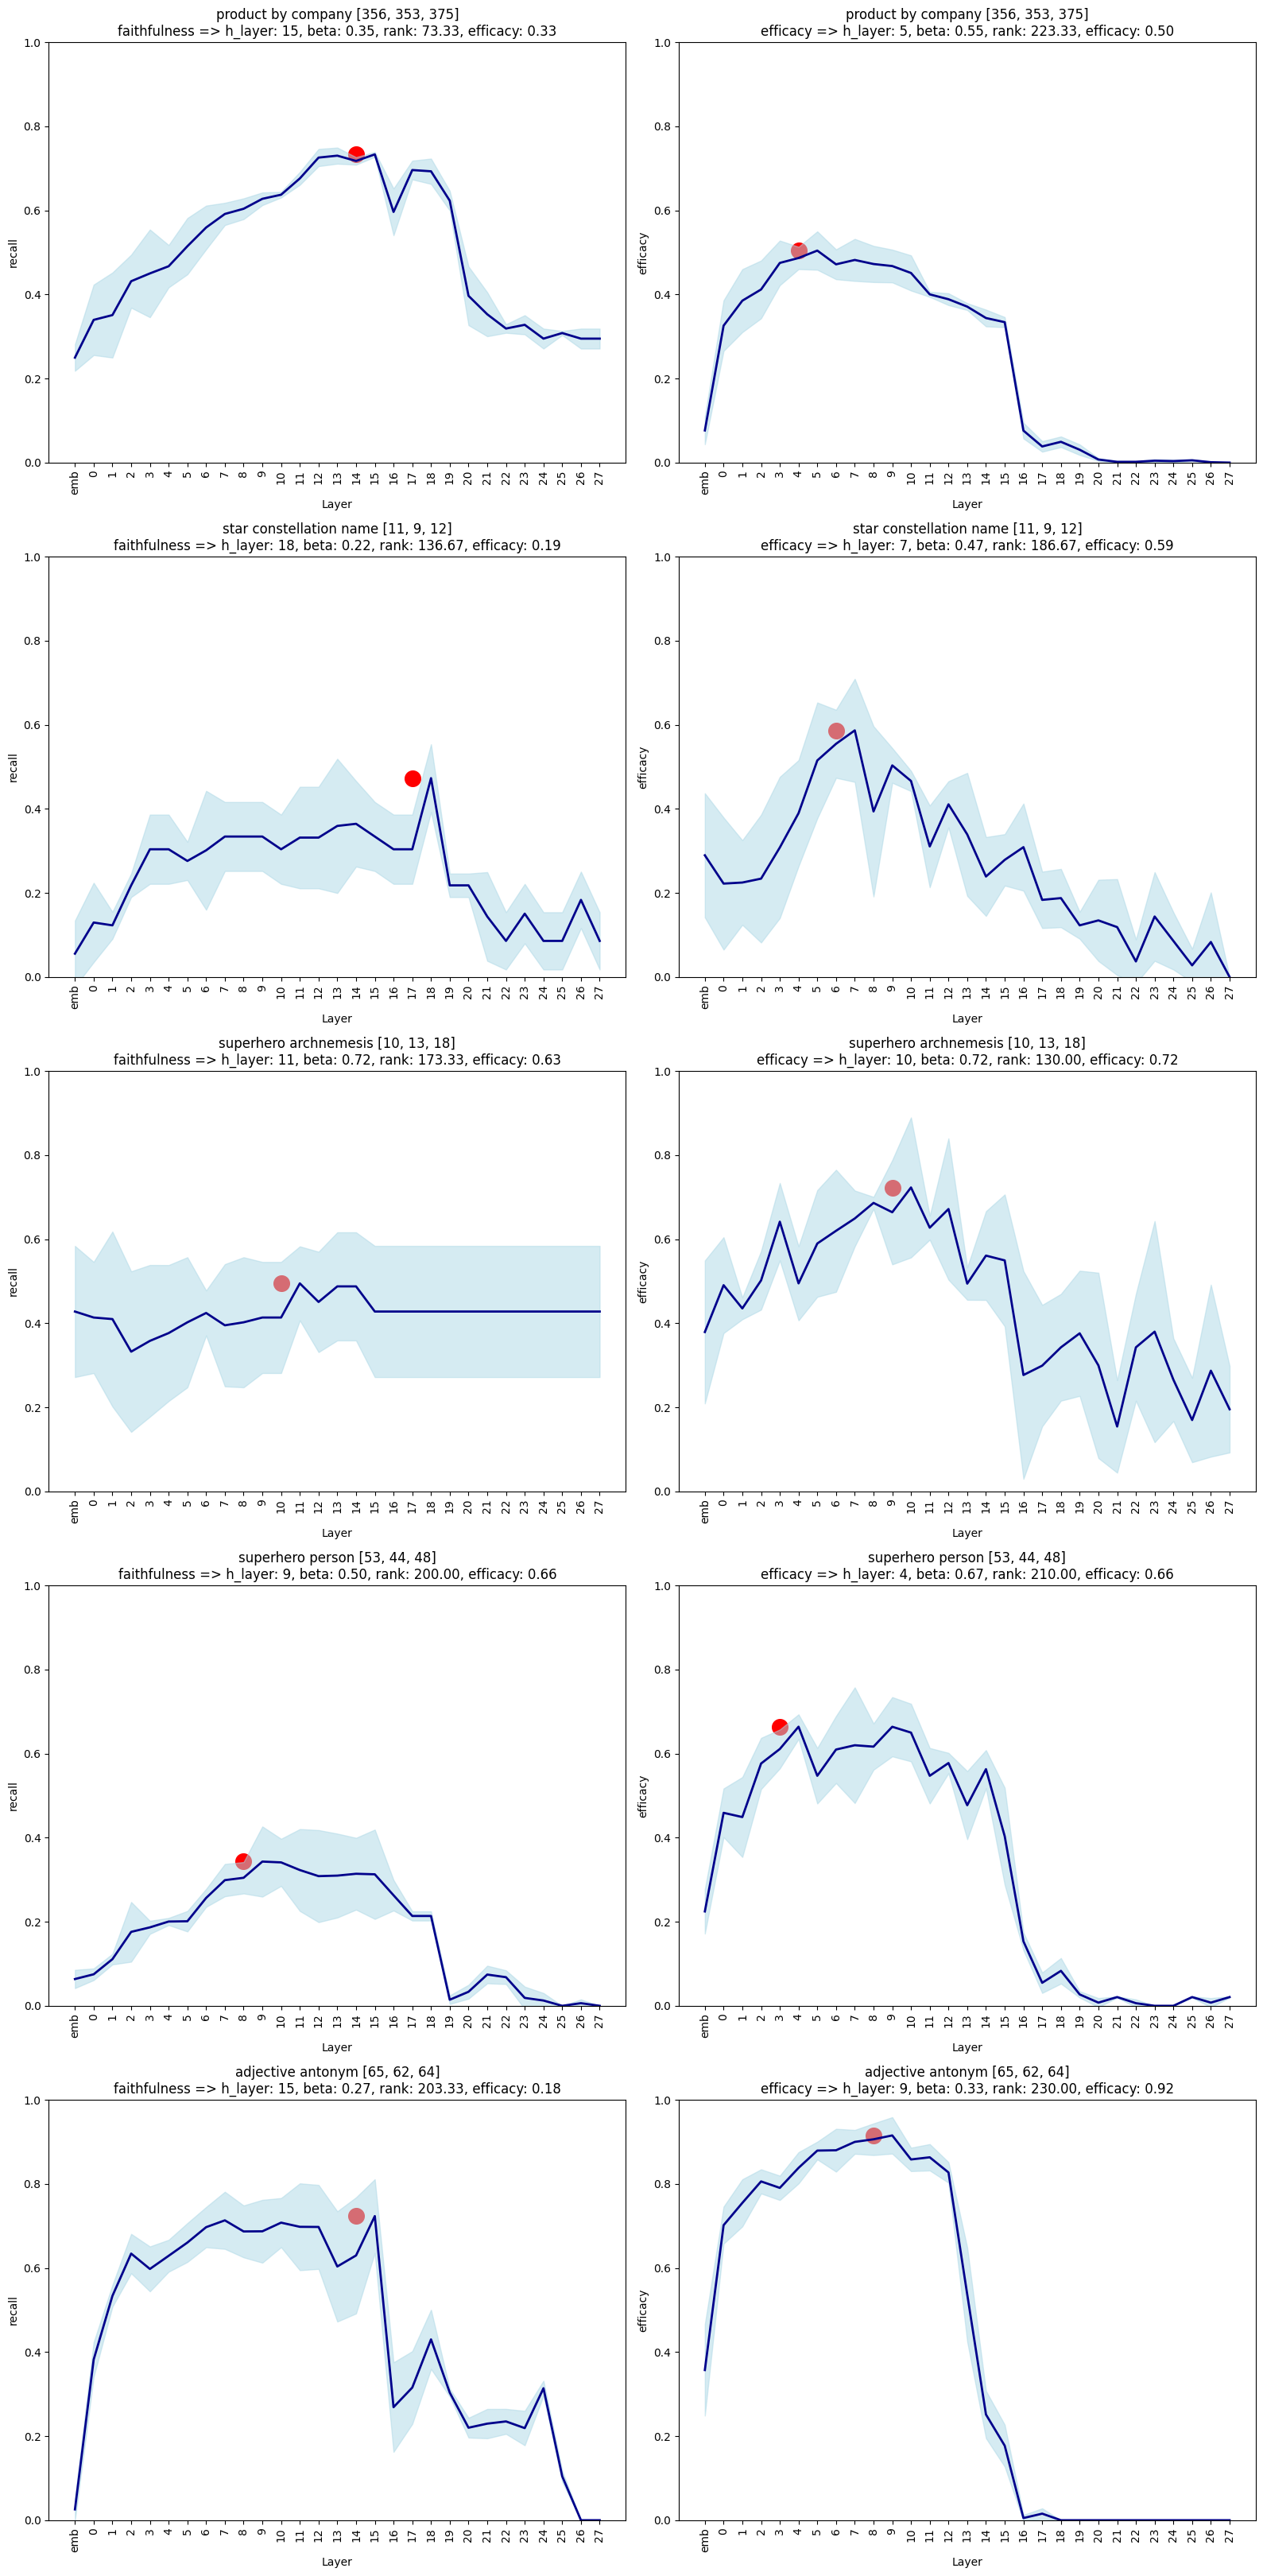

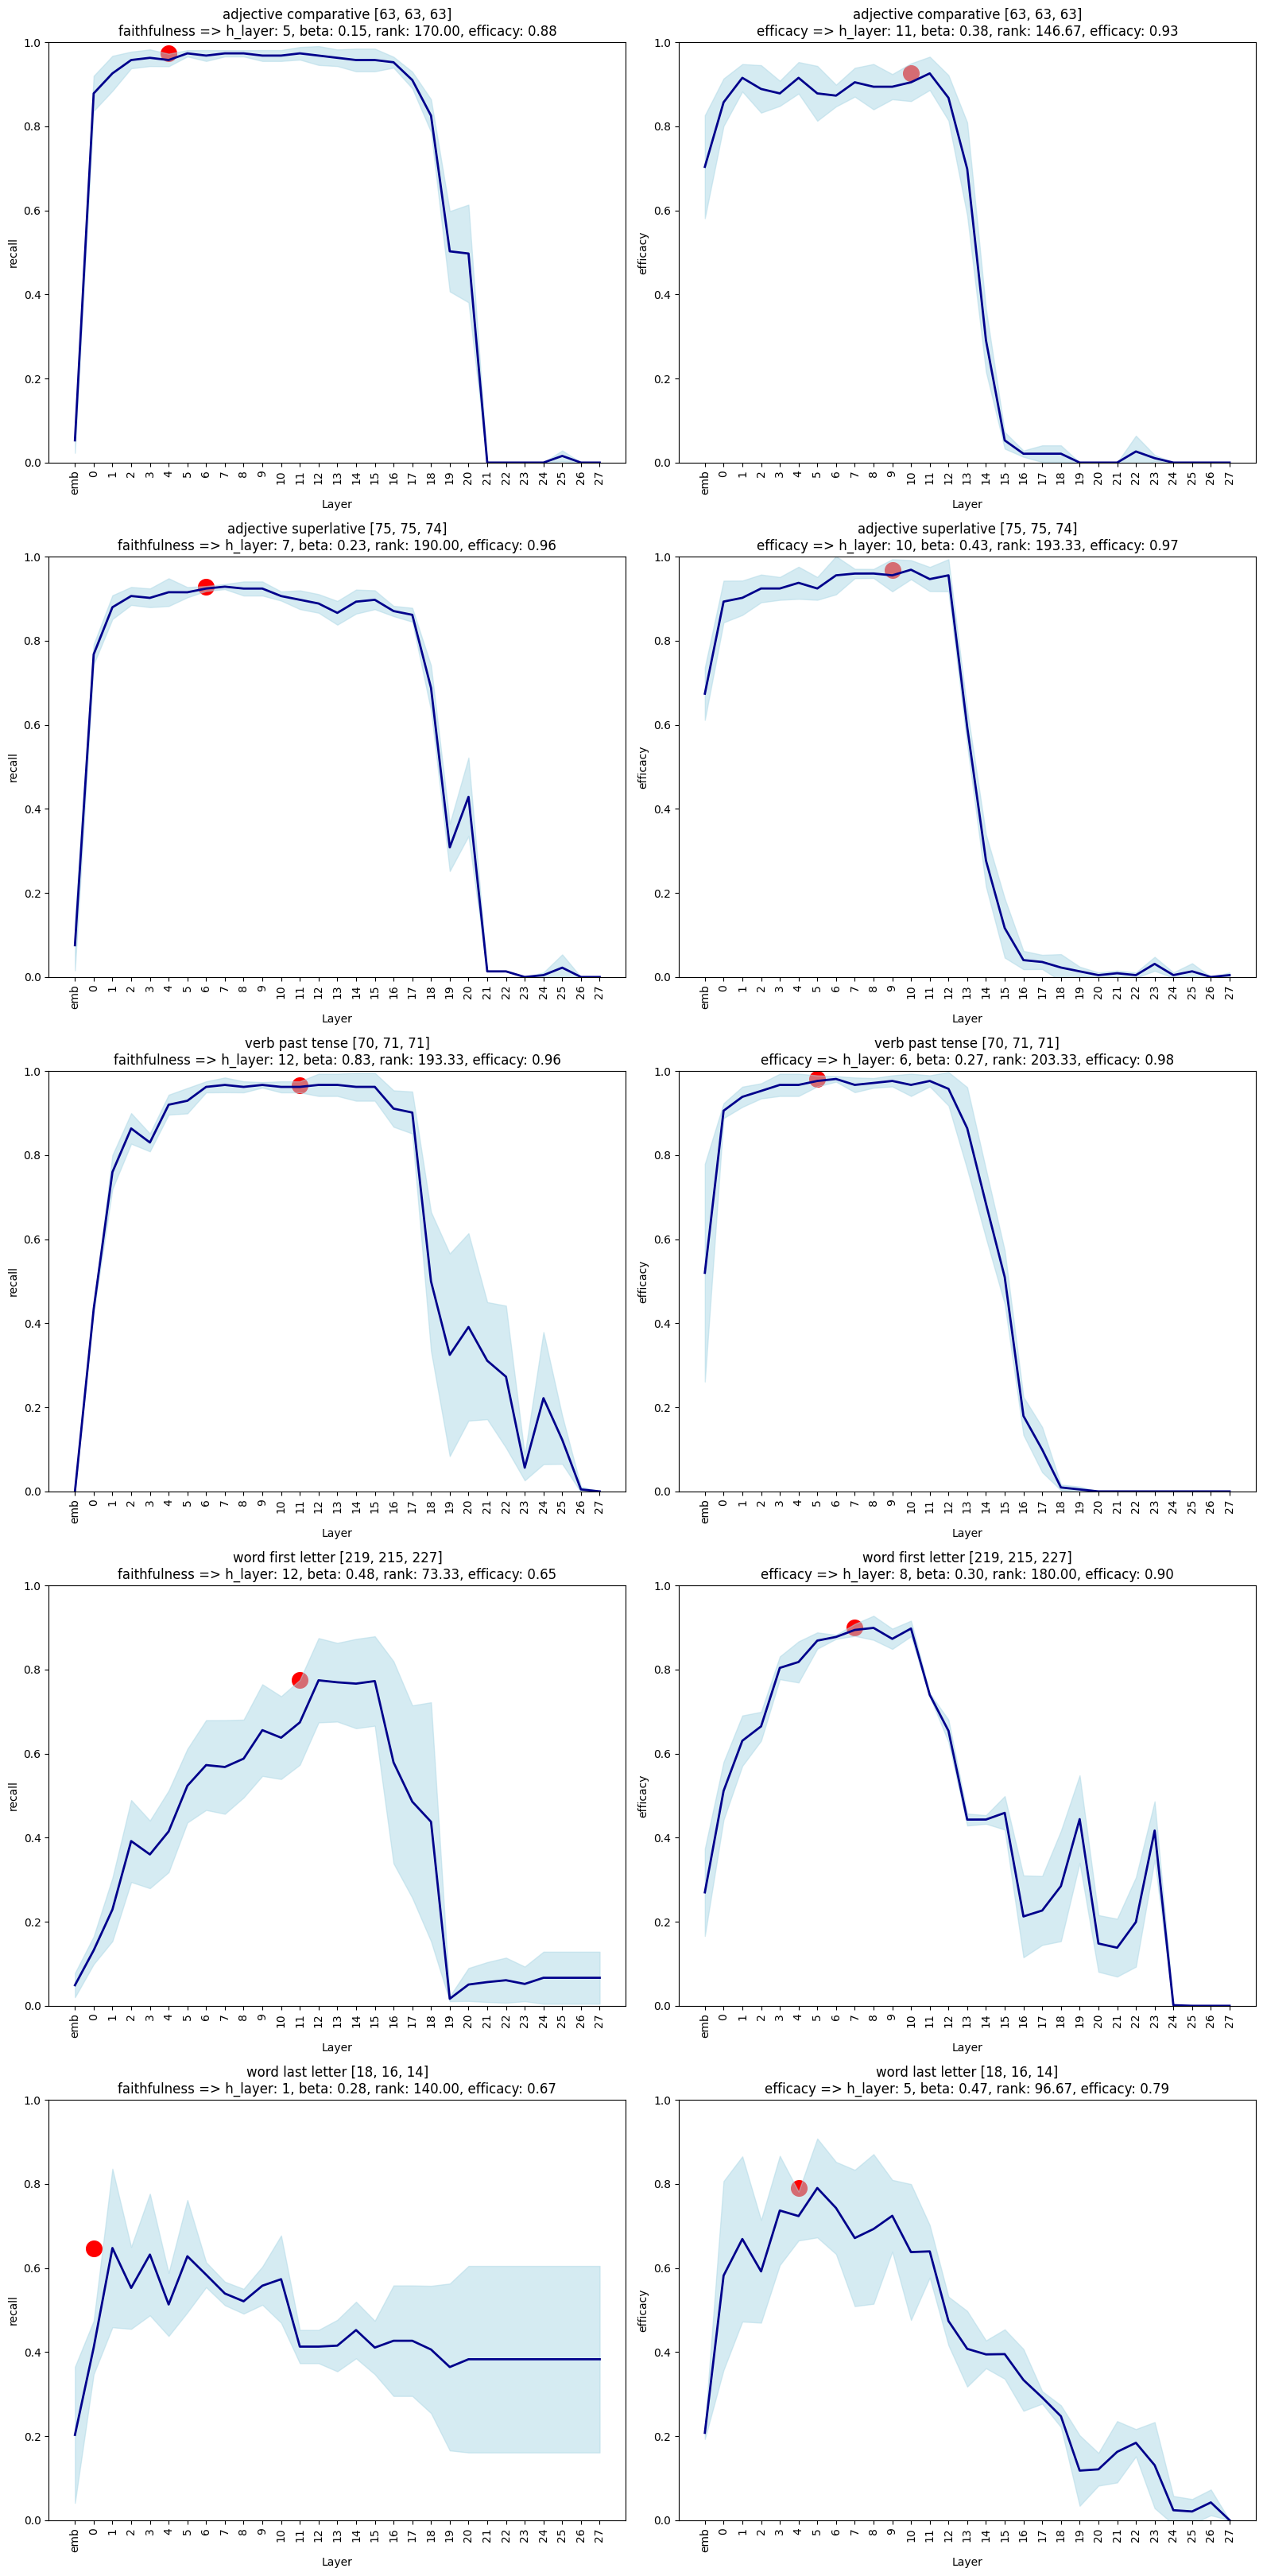

In [34]:
step_size = 5

for _from in range(0, len(filtered_results), step_size):
    _to = min(len(filtered_results), _from + step_size)
    n_subplots = len(filtered_results) * 3
    n_subplots = (_to - _from)  * 2
    ncols=2
    nrows=int(np.ceil(n_subplots/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 6.5))
    if n_subplots == 1:
        axes = [axes]

    ax_col, ax_row = 0, 0
    for i, (relation_name, relation_result) in list(enumerate(filtered_results.items()))[_from  : _to]:
        print(i, relation_name)
        result = parse_results(sweep_results[relation_name])
        plot_layerwise(axes[ax_row][0], result)
        plot_layerwise(axes[ax_row][1], result, attribute="efficacy", best_criterion="efficacy")
        # plot_layerwise(axes[ax_row][2], result, attribute="jh_norm", best_criterion="efficacy")
        ax_row += 1
        # break
    fig.tight_layout()
    fig.show()

In [15]:
sweep_path = f"../../results/sweep/{model_name}"

sweep_results = read_sweep_results(sweep_path)

In [16]:
for relation in sweep_results:
    sweep_results[relation] = parse_results(sweep_results[relation])

In [18]:
def get_recall_vs_efficacy_info(sweep_results, criterion = "best"):
    recalls = []
    efficacies = []
    for relation_name in sweep_results:
        if criterion in ["best", "faithfulness"]:
            recalls.append(sweep_results[relation_name].best_by_faithfulness().recall.mean)
        else:
            recalls.append(sweep_results[relation_name].best_by_efficacy().recall.mean)
        if criterion in ["best", "efficacy"]:
            efficacies.append(sweep_results[relation_name].best_by_efficacy().efficacy.mean)
        else:
            efficacies.append(sweep_results[relation_name].best_by_faithfulness().efficacy.mean)
    return recalls, efficacies

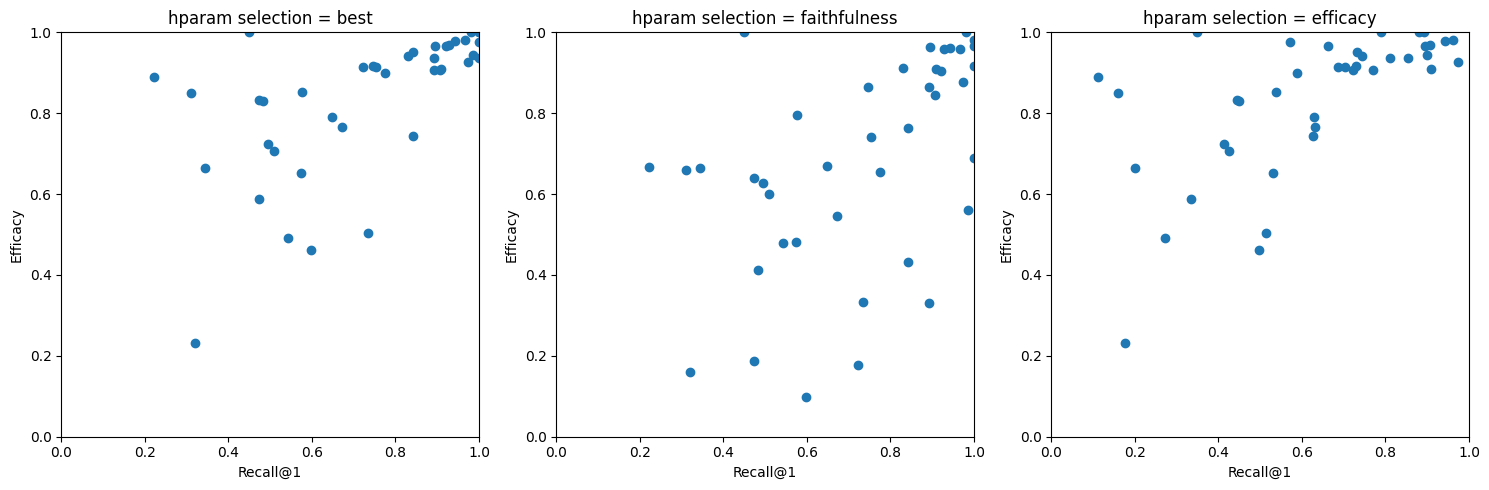

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for criterion, ax in zip(["best", "faithfulness", "efficacy"], axes):
    recalls, efficacies = get_recall_vs_efficacy_info(sweep_results, criterion=criterion)
    ax.scatter(recalls, efficacies)

    ax.set_title(f"hparam selection = {criterion}")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Recall@1")
    ax.set_ylabel("Efficacy")

fig.tight_layout()
fig.show()

In [ ]:
def read_and_parse_sweep_results(sweep_path):
    sweep_results = read_sweep_results(sweep_path)
    for relation in sweep_results:
        sweep_results[relation] = parse_results(sweep_results[relation])
    return sweep_results

In [ ]:
sweep_single_path = f"../../results/sweep-single/{model_name}"
sweep_single = read_and_parse_sweep_results(sweep_single_path)

sweep_multi_path = f"../../results/sweep-multi/{model_name}"
sweep_multi = read_and_parse_sweep_results(sweep_multi_path)

In [ ]:
criterion = "best" # "faithfulness" # "efficacy" # "best

single_recalls, single_efficacies = get_recall_vs_efficacy_info(sweep_single, criterion=criterion)
multi_recalls, multi_efficacies = get_recall_vs_efficacy_info(sweep_multi, criterion=criterion)

plt.scatter(single_recalls, single_efficacies, color = "blue", label = "single", alpha = 0.5)
plt.scatter(multi_recalls, multi_efficacies, color = "red", label = "multi", marker = "s", alpha = 0.5)

plt.title(f"Efficacy vs Recall ({criterion})")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Recall")
plt.ylabel("Efficacy")
plt.legend()

In [ ]:
def plot_betawise(canvas, relation_result, recall_at = 1):
    best_layer = result.best()

    beta_recalls = {}
    for trial in relation_result.trials:
        layer = trial.layers[best_layer.layer]
        for beta in layer.result.betas:
            if beta.beta not in beta_recalls:
                beta_recalls[beta.beta] = []
            beta_recalls[beta.beta].append(beta.recall)
    for beta in beta_recalls:
        beta_recalls[beta] = np.array(beta_recalls[beta]).mean(axis = 0)

    betas = list(beta_recalls.keys())
    recalls = [
        beta_recalls[beta][recall_at-1]
        # beta_recalls[beta].mean() 
        for beta in betas
    ]
    canvas.plot(betas, recalls, color='darkblue', linewidth=2)
    canvas.vlines(best_layer.beta.mean, 0, 1, color="darkred", linewidth=2)

    canvas.set_ylim(0, 1)
    canvas.set_xlabel("Layer")
    canvas.set_ylabel("Recall")
    canvas.set_xticks(betas, [np.round(b, 2) for b in betas], rotation=90)
    canvas.set_title(f"{relation_result.relation_name} | h_layer: {best_layer.layer}, beta: {best_layer.beta.mean:.2f}")
    
    return canvas

In [ ]:
n_subplots = len(filtered_results)
ncols=3
nrows=int(np.ceil(n_subplots/ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 6.5))
if n_subplots == 1:
    axes = [axes]

ax_col, ax_row = 0, 0
for i, (relation_name, relation_result) in enumerate(filtered_results.items()):
    result = parse_results(sweep_results[relation_name])
    plot_betawise(axes[ax_row][ax_col], relation_result)
    ax_col += 1
    if ax_col == ncols:
        ax_col = 0
        ax_row += 1
fig.show()

In [ ]:
result.best()